# Kortdage 2025 - Introdoktion til Python - Raster 
## Hvorfor arbejde med raster? 
Raster giver nogle andre muligheder end vektordata, da man typisk kan få dækket større arealer på én gang og danne grundlag for fx bydækkende eller landsdækkende datasæt. 
Man kan fx bruge den nationale højdemodel til at lave klimatilpasningsanalyser, finde højde på bygninger og andre ting.

I findes der en masse gratis og offentlig tilgængelige rasterdata, specielt i form af satellitbilleder. Både ESA og NASA udstiller mange af deres produkter gratis og de kan med relativt simple analyser bruges i den offentlige forvaltning. 

I disse øvelser bliver der anvendt billeder fra NASA's satellitter Landsat. Landsat-missionen har eksisteret siden 1970'erne og er bredt anvendt i forskning og offentlig forvaltning. Vi skal kun bruge data på overfladetemperaturer, for at vise et eksempel på, hvordan overfladetemperaturerne i en dansk by varierer bare på en enkelt dag. 

Der er tre øvelser: 
1. Indlæsning af raster og vektordata samt simple plots
2. Undersøgelse af gennemsnitsoverfladetemperaturen i nogle administrative områder
3. Indeksering af raster 
4. Udpegning af de varmeste områder



### Øvelse 1 - import af data 
Installation af libraries. Nogle af de libraries, der anvendes, når man arbejder med raster er ikke så gængse i python-verdenen. 
Det mest anvendte er rasterio, men numpy kan også bruges til at løse mange opgaver

In [4]:
!pip install geopandas
!pip install pandas
!pip install rasterio
!pip install rasterstats
!pip install owslib
!pip install matplotlib


'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


Indlæsning af libraries. Når libraries er installeret skal de indlæses, så de kan anvendes i scriptet. Bemærk at flere af dem indlæses med et alias (fx import geopandas as gpd). Det gøres for at slippe for at skrive hele navnet, når man skal kalde en funktion. 

In [94]:
import geopandas as gpd 
import pandas as pd

import numpy as np
import rasterio
from rasterio.plot import show

from rasterstats import zonal_stats
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable


**Indlæsning af data**

Til opgaven skal der anvendes et rasterbillede og noget vektordata. 
Rasterdata kan indlæses på flere måder. Rasterio har en relativ simpel 'open' funktion, hvor båndene i en rasterfil kan indlæses ét af gangen ellere flere på samme tid. 
I dette tilfælde har rasterfilen kun et bånd og det indlæses i variablen 'uhiraster' ved at bruge stien til billedet.

Vektordata kan også indlæses på flere måder. I dette tilfælde anvendes Geopandas, som også blev anvendt i den første del af workshoppen. 
Vektordataen kommer fra en geopackage og bliver indlæst med geopandas funktionen 'read_file'. Der kan også indlæses data fra andre filformater, databaser og diverse web-services. 

In [109]:
# Url til billedets placering 
# inputuhi = r"/content/sample_data/lst_nykoebing_f_2025_celcius.tif"
inputuhi = r'D:\Projekter\Kortdage\python_kortdage\lst_nykoebing_f_2025_celcius.tif'

# Åbn billedet med rasterio. Læs bånd nr. 1 og definer datatypen som float.
# uhiraster = rasterio.open(inputuhi).read(1).astype(float)
# Open raster with rasterio
with rasterio.open(inputuhi) as src:
    uhiraster = src.read(1)  # read the first band
    transform = src.transform
    raster_crs = src.crs

# No-data værdien i dette billede er sat til en negativ værdi, så alle celler, der er under 0, sættes til No Data (her er et eksempel på, hvordan numpy kan bruges med rasterdata)
uhiraster[uhiraster < 0] = np.nan 

#***Indlæs vektordata ***
# Sti til geopackage defineres
# url = "/content/sample_data/nykoebing_afstemningsomraader.gpkg"
url =r"D:\Projekter\Kortdage\python_kortdage\nykoebing_afstemningsomraader.gpkg"

# Geopandas bruges til at indlæse filen. Herefter defineres koordinatsystemet 
admin_gr_gdf = gpd.read_file(url)
admin_gr_gdf = admin_gr_gdf.set_crs(epsg=25832, inplace=True,allow_override=True)

# For lige at tjekke at data ser ud som forventet, printes tabellen
admin_gr_gdf.head()

,id,navn,redigeringsret,dataspecifikation,landekode,skala,udtraeksdato,afstemningsomraadenummer,afstemningsstednavn,kommunekode,kommunelokalid,opstillingskredsnummer,geometry
0,dagi.701828,Sundby,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,07,Sundskolen,0376,389151,30,"MULTIPOLYGON (((680550.66 6073168.09, 680808.2..."
1,dagi.706380,Lindeskov,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,03,Østerbroskolen,0376,389151,30,"MULTIPOLYGON (((684956.86 6071360.02, 684965.0..."
2,dagi.706386,Ejegod,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,04,Ejegodhallen,0376,389151,30,"MULTIPOLYGON (((679788.29 6076915.89, 679797.6..."
3,dagi.709646,Byen,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,01,Nykøbing F. Hallen,0376,389151,30,"MULTIPOLYGON (((683973.38 6073087.57, 683975 6..."
4,dagi.703554,Østerbro,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,02,Brydeklubben Thor,0376,389151,30,"MULTIPOLYGON (((684500.67 6071807.7, 684500.86..."


**Simpelt plot**

Der er endeløse muligheder for at plotte sit data. 
Herunder plotter vi både rasterbilledet og afstemningsområderne. 

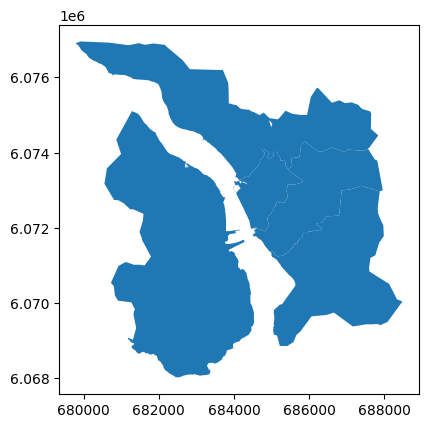

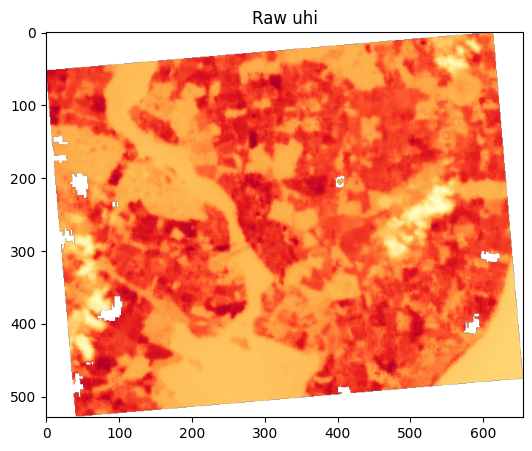

In [89]:
# Plot af afstemningsområderne
admin_gr_gdf.plot()

# Plot af rasterbilledet 
fig, ax = plt.subplots(figsize=(10, 5))
chm_plot = ax.imshow(uhiraster, cmap='YlOrRd' )

ax.set_title("Raw uhi")
plt.show()

**Subplots**

En lidt pænere og strømlinet måde at plotte flere datasæt er ved at lave et subplot. 
Her kan man definere en form for grid, hvor man kan placere sine plots inde i, så de har den samme størrelse, deler signaturforklaringer, akserne bliver ens, så man kan sammenligne data bedre mm

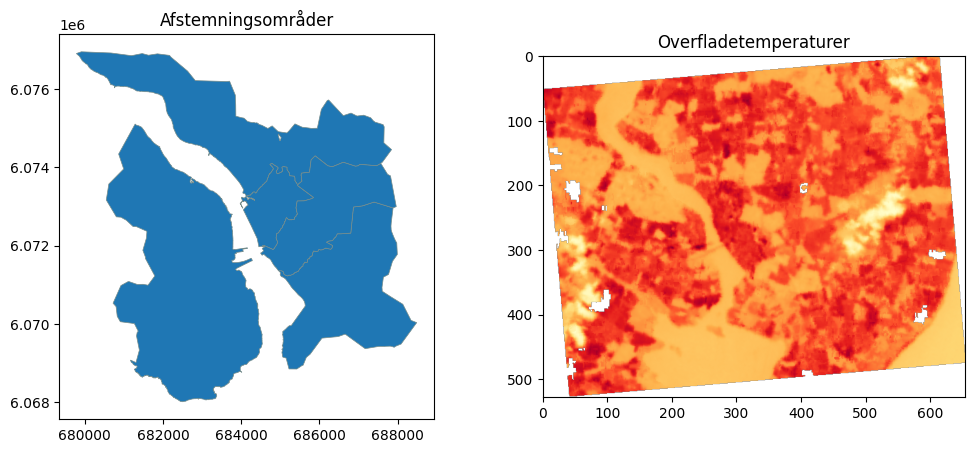

In [33]:
# Definer størrelse på subplot 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# First scatterplot
fig_afstemningsomr = admin_gr_gdf.plot(
    linewidth=0.5,
    edgecolor='#768c8a',
    ax=ax[0],
)

# Definer overskrift 
ax[0].set_title("Afstemningsområder")

# Plot rasterbilledet
chm_plot = ax[1].imshow(uhiraster, cmap='YlOrRd' )

# Definer overskrift 
ax[1].set_title("Overfladetemperaturer")

plt.show()


### Øvelse 2 - zonal statistics.

Man kan rigtig meget med rasterbilleder i sig selv, men det er ofte brugbart undersøge værdierne i en raster inden for nogle definerede områder. 
Det gør det lidt nemmere at præsentere data og fx bruge data til at lave indsatsområder eller undersøge udvikling over tid. 

Når data skal præsenteres for beslutningstagere er det også ofte nemmere at præsentere data inden for de samme grænser og det bliver nemmere at sammenligne forskellige analyser. 

I dette eksempel skal vi finde gennemsnitsoverfladetemperaturen inden for afstemningsområderne vi har indlæst overfor. 
Hvis vi fx også undersøgte befæstelsesgraden eller vegetationsdækket inden for de samme områder, ville vi nemt kunne lave en grov sammenligning af disse parametre



**Zonal statistics**

Zonal statistics er en gængs måde at undersøge rasterværdier inden for polygoner. Funktionen findes også i de fleste GIS-programmer og er en nyttig måde at bringe de to datatyper sammen

I dette eksempel bruger vi et library, zonal_stats, som vi indlæse i toppen af scriptet. 

In [43]:
# Kør funktionen med afstemningsområderne og overfladetemperaturerne. Bemærk, at indlæsningen af rasterfilen er direkte fra tif-filen 
# Der kan laves forskellige aggregeringer (fx max-værdier, standardafvigelser mm). Her er vi kun interesseret i gennemsnittet. 
zs_uhi_adminomraader = zonal_stats(admin_gr_gdf, inputuhi, stats='mean',geojson_out=True)

# Resultatet af zonals stats er en geojson. For at vi nemmere kan arbejde videre med den, konverteres den til en geodataframe 
gdf_uhi_adminomraader =  gpd.GeoDataFrame.from_features(zs_uhi_adminomraader)

# Resultatet plottes. Resultaten af zonals er en tilføjet kolonne med værdien/værdierne, man har defineret i funktionen, så i dette tilfælde er der tilføjet et kolonne med 'mean'
gdf_uhi_adminomraader.head(2)

,geometry,id,navn,redigeringsret,dataspecifikation,landekode,skala,udtraeksdato,afstemningsomraadenummer,afstemningsstednavn,kommunekode,kommunelokalid,opstillingskredsnummer,mean
0,"MULTIPOLYGON (((680550.66 6073168.09, 680808.2...",dagi.701828,Sundby,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,07,Sundskolen,0376,389151,30,30.303562
1,"MULTIPOLYGON (((684956.86 6071360.02, 684965.0...",dagi.706380,Lindeskov,Kommune,DAGI Objektspecifikation version 2.0,DK,1:10.000,2025-09-15 15:06:29,03,Østerbroskolen,0376,389151,30,29.007932


Øvelse: Prøv at få både gennemsnit og max-værdi i zonal statistics. 

Dokumentation kan ses her https://pythonhosted.org/rasterstats/

In [44]:
# Kopier koden fra ovensående afsnit og prøv dig frem 

Svaret ligger herunder 

In [ ]:
# Klik på pilen for at se svaret 

zs_uhi_adminomraader_mean_max = zonal_stats(admin_gr_gdf, inputuhi, stats='mean max',geojson_out=True)

gdf_uhi_adminomraader_mean_max =  gpd.GeoDataFrame.from_features(zs_uhi_adminomraader_mean_max)

gdf_uhi_adminomraader_mean_max.head(2)

**Plot gennemsnitsværdier inden for grænser**

Resultaterne plottes. Her kan der virkelig leges med farver, signaturforklaring mm 

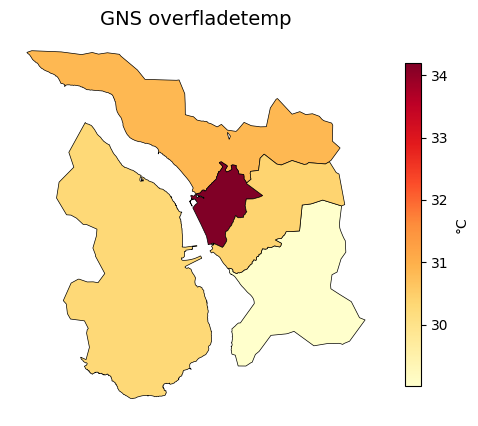

In [42]:
# Definer størrelse på figuren, som plottet skal være inde i 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

fig = gdf_uhi_adminomraader.plot(
    column='mean',                  # Den kolonne, der skal farvelægges efter 
    cmap='YlOrRd',                  # man kan bruge en af de mange prædefinerede farvepaletter eller evt. lave sin egen. 
                                    # De prædefinerede kan ses her: https://matplotlib.org/stable/users/explain/colors/colormaps.html 
    linewidth=0.5,                  # Linjebredde på polygonerne
    edgecolor = 'black',            # Farve på linjer. Her kan der også anvendes HEX-koder
    legend= True,                   # True = der er signaturforklaring, False = ingen signaturforklaring
    ax=ax,                          # Definerer hvilket subplot, plottet skal være i 
    legend_kwds={
    'label': "°C", 'shrink': 0.7}   # Definerer parametre til signaturforklaringen. 
                                    #Mulighederne kan ses her: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar   
    )

# Definer titel 
ax.set_title("GNS overfladetemp", fontsize=14)

# Fjern akserne (koordinaterne i siden)
ax.axis('off')
plt.show()

Øvelse: lav et plot med visning af max-værdierne i stedet for mean. Husk at vær opmærksom på navnet på geodataframen 

In [49]:
# Kopier ovenstående plot og prøv dig frem. Du kan også prøve at skifte farvepaletten ud eller ændre i legendens opsætning

In [ ]:
# Svaret kan også findes her (Klil på pilen)

# Definer størrelse på figuren, som plottet skal være inde i 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

fig = gdf_uhi_adminomraader_mean_max.plot(
    column='max',                  # Den kolonne, der skal farvelægges efter 
    cmap='turbo',                  # man kan bruge en af de mange prædefinerede farvepaletter eller evt. lave sin egen. 
                                    # De prædefinerede kan ses her: https://matplotlib.org/stable/users/explain/colors/colormaps.html 
    linewidth=0.5,                  # Linjebredde på polygonerne
    edgecolor = 'black',            # Farve på linjer. Her kan der også anvendes HEX-koder
    legend= True,                   # True = der er signaturforklaring, False = ingen signaturforklaring
    ax=ax,                          # Definerer hvilket subplot, plottet skal være i 
    legend_kwds={
    'label': "°C", 'shrink': 0.7}   # Definerer parametre til signaturforklaringen. 
                                    #Mulighederne kan ses her: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar   
    )

# Definer titel 
ax.set_title("GNS overfladetemp", fontsize=14)

# Fjern akserne (koordinaterne i siden)
ax.axis('off')
plt.show()

### Øvelse 3 - Indeksering af raster 

Det kan ofte være en god idé at lave en indeksering af rasterværdier, for at gøre det nemmere at sammenligne med andre datsæt, hvor værdierne eller datatyperne er meget forskellige. 
Med indeksering menes der at reklassificere værdierne ind i nogle prædefinerede numeriske klasser. 

I dette eksempel vil vi gerne have fem styks, hvor værdierne går fra 1-5 defineret ud fra minimum og maxværdierne i billedet. 

Man kan også lave en reklassificering ud fra nogle faste intervaller, man selv definerer manuelt eller automatisk 

Der er igen mange veje til rom. En af de nemmeste veje er at bruge librariet numpy til at definere antallet af klasser og lave inddelingen: 

In [60]:
# Sørg for at det kun er celler der har en værdi, der kommer med 
valid_mask = ~np.isnan(uhiraster)
valid_values = uhiraster[valid_mask]

# Definer antallet af klasser samt grænseværdierne for dem. Grænserne sættes ud fra mininum og maksimum værdierne i datasættet. 
n_classes = 5
bins = np.linspace(np.nanmin(uhiraster), np.nanmax(uhiraster), n_classes + 1)

# Reklassificer vha klasserne defineret ovenfor 
reclassified_uhi = np.zeros_like(uhiraster, dtype=int)  
reclassified_uhi[valid_mask] = np.digitize(valid_values, bins, right=False)

Plot resultatet

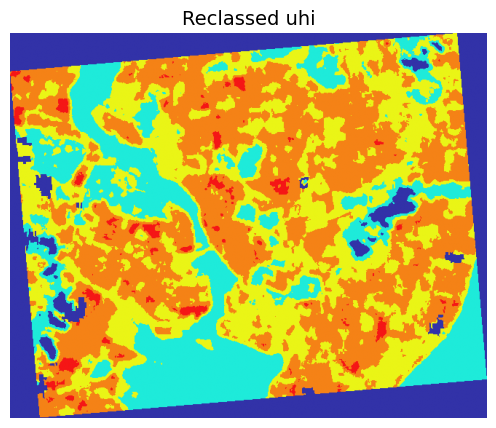

In [65]:
# Plot det reklassificerede 
fig, ax = plt.subplots(figsize=(10, 5))

# Definer de farver, man gerne vil bruge til plottet 
cmap = ListedColormap(["#3232a8", "#1eebda", "#eaf516", "#f58216","#f51616"])

chm_plot = ax.imshow(reclassified_uhi, cmap=cmap )

ax.set_title("Reclassed uhi", fontsize=14)
ax.axis('off')
plt.show()

### Øvelse 4 - udpegning af de varmeste områder 

Standardafvgielse bruges til at definere grænsen. Den kan også være manuelt defineret. 

In [131]:
merged_omr = admin_gr_gdf[['id','geometry']].dissolve()

uhi_std = zonal_stats(merged_omr, inputuhi, stats='mean std',geojson_out=True)
gdf_uhi_std =  gpd.GeoDataFrame.from_features(uhi_std)

mean_value = uhi_std[0]["properties"]["mean"]

std_value = uhi_std[0]["properties"]["std"]

uhi_graense = mean_value+(std_value*2)

print('Grænsen for UHI er: ',round(uhi_graense,1),'°C')


Grænsen for UHI er:  38.6 °C


**Filtrering af billedet efter grænseværdien og plot**

For at visualisere de områder, hvor der er varmest, skal billedet med overfladetemperaturer reklassificeres, så alle celler under grænseværdien fjernes. 
I samme omgang klippes rasterbilledet, så det kun er celler inden for afstemningsområderne, der er med. 

Til reklassificeringen anvendes numpy 

In [135]:
# For at klippe i rasterbilledet opløses grænserne mellem afstemningsområderne, så der kun ét polygon. 
clipmask = admin_gr_gdf.dissolve()

# Herefter åbnes det originale rasterbillede, det klippes og herefter fjernes alle værdier under grænseværdien 
with rasterio.open(inputuhi) as src:

    # Klip billedet, så pixels uden for polygonerne er væk
    out_img, out_transform = mask(src, clipmask.geometry, crop= True)
    
    # Fjern værdier under grænseværdien
    uhi = np.where(out_img[0] >= uhi_graense, 1, np.NaN)

Plot af resultatet

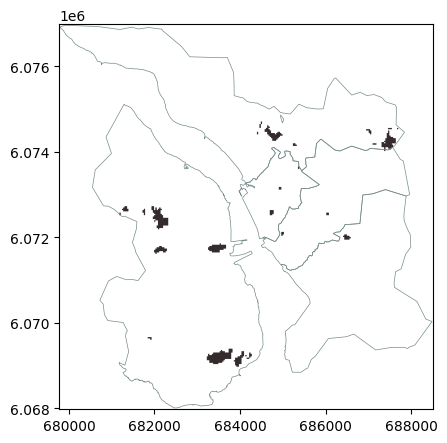

In [136]:
# Plot resultatet og brug afstemningsområderne som en simpel baggrund
fig, ax = plt.subplots(figsize=(10, 5))

cmap = ListedColormap(["#352b2d"])
# Plot billede
show(uhi, transform=out_transform, cmap=cmap, ax=ax)

# Plot grænser 
fig_afstemningsomr = admin_gr_gdf.boundary.plot(
    linewidth=0.5,
    edgecolor='#768c8a',
    ax=ax
)

plt.show()